# 確率モデル

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy as sp
from scipy.stats import uniform, bernoulli, binom, norm, poisson, expon

# 日本語フォントの設定（Mac:'Hiragino Sans', Windows:'MS Gothic'）
plt.rcParams['font.family'] = 'Hiragino Sans'

本章の内容は，文献{cite}`Odaka2018, TokyoUniv2019` を参考にしている．

<!-- ## 確率モデルとは？ -->

確率モデルとは，数理モデルの変数が確率変数となっているモデルであり，自然現象から社会現象まで様々な現象の記述に用いられる．
例えば，コイン投げは，表と裏が一定の確率で出るという数理モデルで記述でき，これは最も基本的な確率モデルである．
また，株価の変動は，毎時刻ごとに株価の上がり幅と下がり幅が確率的に決まるようなモデル（ランダムウォーク）によって記述することができる．
本章では，確率モデルをシミュレーションする際に必要な乱数について述べた後，確率モデルにおいて重要な大数の法則と中心極限定理，そしてランダムウォークについて説明する．


## 乱数の生成

ある数列が与えられたとき，数の並び方に規則性や周期性がない場合，この数列の各要素を**乱数**と呼ぶ．
乱数を生成するにはいくつかの方法がある．
例えば，サイコロを振って出た目を記録するだけでも，1〜6の数値から成る乱数を生成することができる．
また，カオスや量子力学などのランダムな物理現象を利用した乱数は**物理乱数**と呼ばれ，規則性や周期性がない真の乱数として研究されている．

一方，コンピュータ上でアルゴリズムにしたがって乱数を生成する方法もある．
このように生成された乱数は**疑似乱数**と呼ばれる．
疑似乱数はアルゴリズムが分かれば値を予測することができてしまうが，シミュレーションのためには逆にこの性質が長所となる．
また，アルゴリズム次第で十分にランダムに見える値を高速に生成することができることも長所である．
一方，疑似乱数にはある種の周期性が現れてしまうという欠点があるため，これを解決するための様々なアルゴリズムが提案されている．

### 一様乱数

乱数の中で最も基本的なものは，ある範囲の値が同じ確率で出現する**一様乱数**である．
一様乱数は，一様分布に従う確率変数の実現値と捉えることができ，様々な確率モデルの構築に用いられる．

#### 線形合同法

一様乱数を生成するアルゴリズムの中で，最も基本的なものが**線形合同法**である．
線形合同法にはいくつかの問題があるため，精度が求められる大規模なシミュレーションには使われないが，手軽に乱数を生成したりアルゴリズムの基礎を理解するためには便利である．

```{admonition} 線形合同法のアルゴリズム
1. 以下の大小関係を満たすように整数 $ a, b, M $ を決める：
   
   $$
    0 < a < M\\
    0 \leq b < M
   $$
   
2. 乱数列の初期値 $ x_0 $ を決める（乱数の**シード**と呼ぶ）．
3. 以下の漸化式によって乱数列 $ \{x_n\} $ を生成する：
    
    $$
    x_{n+1} = (ax_{n} + b) \% M
    $$
    
    ここで，$ \% $ は剰余を表す．

```

以上のアルゴリズムを用いると，$ 0 $ 以上 $ M-1 $ 以下の乱数列を得ることができる．
また，$ a, b, M $ がいくつかの条件を満たすと，最大周期が $ M $ となることが知られてため{cite}`TokyoUniv2019`，良い乱数を生成するためには条件を満たした上で $ M $ を大きく取る方が良い．
例えば，$ M=2^{32},\ a=1664525,\ b=1013904223 $ の場合には，最大周期が $ 2^{32} $ となる．

なお，$ M $ が偶数の場合には偶数と奇数が交互に出現してしまうなど，実用的には問題も多い．

**Pythonでの実装**

まず，アルゴリズムに従って素朴に実装すると以下のようになる．

In [2]:
a, b, M = 1664525, 1013904223, 2**32

U = np.array([0])
for i in range(10):
    U = np.append(U, (a*U[i] + b) % M)
print(U)

[         0 1013904223 1196435762 3519870697 2868466484 1649599747
 2670642822 1476291629 2748932008 2180890343 2498801434]


次に，$ x_{\mathrm{min}} $ 以上 $ x_{\mathrm{max}} $ 以下の一様乱数を生成する汎用的な関数を作成する．

In [25]:
# 線形合同法により[0, 1)の一様乱数を生成する
def lcg(seed=1, size=100, umin=0, umax=1):
    a, b, M = 1664525, 1013904223, 2**32

    U = np.array([seed])
    for i in range(size-1):
        U = np.append(U, (a*U[i] + b) % M)

    return umin + (umax - umin) * U / M

In [26]:
U = lcg(seed=10, size=1000, umin=0, umax=100)

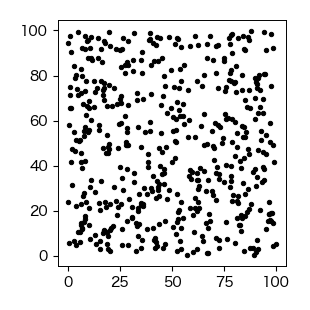

In [5]:
# 乱数列の相関を調べる
U2 = U.reshape(-1, 2)
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(U2[:, 0], U2[:, 1], s=10);

#### より性能の良い一様乱数生成アルゴリズム

線形合同法は，周期性の問題などがあるため，実用的にはより性能の良いアルゴリズムが用いられる．
例えば，NumpyやSciPyでは，高速で長い周期を持つ一様乱数を生成するために，[メルセンヌ・ツイスタ](http://www.math.sci.hiroshima-u.ac.jp/m-mat/TEACH/ichimura-sho-koen.pdf)やPCG64などのアルゴリズムを選ぶことができる．

※ ライブラリのバージョンアップによって変わる可能性がある．

In [17]:
# Scipyを用いて[0, 1)の一様乱数を生成する
sp.stats.uniform.rvs(size=10)

array([0.63527495, 0.78701413, 0.06537002, 0.84649609, 0.79522151,
       0.47753628, 0.01734134, 0.79167788, 0.02783389, 0.84118514])

In [24]:
# Numpyを用いて[0, 1)の一様乱数を生成する
rng = np.random.default_rng(123) # シードを123に設定
rng.random(10) 

array([0.68235186, 0.05382102, 0.22035987, 0.18437181, 0.1759059 ,
       0.81209451, 0.923345  , 0.2765744 , 0.81975456, 0.88989269])

### 任意の確率分布に従う乱数

#### 逆関数法

ある確率分布に従う乱数を生成したいとする．
もし，求めたい確率分布について，その累積分布関数の逆関数が求まるならば，以下の**逆関数法**が適用できる．

```{admonition} 逆関数法のアルゴリズム
1. 求めたい確率分布の累積分布関数 $ F(x) $ を求める．
2. $ F(x) $ の逆関数 $ F^{-1} $ を計算する．
3. $ [0, 1) $ の一様乱数 $ U $ に対し， $ F^{-1}(U) $ を計算する．
```

```{admonition} 逆関数法の証明
:class: dropdown

$ [0, 1] $ の範囲の一様乱数を $ U $ とすると，累積分布関数は

$$
    P(U \leq u) = u
$$

と表される．
ここで，求めたい確率分布の累積分布関数を $ F(x) $ とし，その逆関数 $ F^{-1} $ が求まったとする．
このとき，上の式は

$$
    P(F^{-1}(U) \leq F^{-1}(u)) = u
$$

と変形できる．
よって，$ F^{-1}(u) = x $ と変数変換すれば，$ u = F(x) $ であるので，

$$
    P(F^{-1}(U) \leq x) = F(x)
$$

を得る．
以上より，一様乱数 $ U $ に対して，新たな確率変数を $ X=F^{-1}(U) $ と定義すると，$ X $ は求めたい確率分布 $ F(x) $ に従う．
```

**例）指数分布**

指数分布の確率密度関数は以下のように与えられる：

$$
    f(x) = \frac{1}{\lambda} e^{-\frac{x}{\lambda}}
$$

よって，その累積分布関数は

$$
    F(x) =  1 - e^{-\frac{x}{\lambda}}
$$

となり，その逆関数は $ F(x)=u $ と置くと，

$$
    F^{-1}(u) = -\lambda \log(1-u)  
$$

と求まる．
これより，[0, 1)の一様乱数 $ u $ に対して，$ -\lambda \log(1-u) $ は指数分布に従うことが分かる．

以下は，線形合同法を用いて生成した一様乱数から指数乱数を生成する例である．

In [27]:
# 線形合同法で[0, 1)の一様乱数を生成する
U = lcg(seed=10, size=1000, umin=0, umax=1)

# 逆関数法で指数乱数に変換する
lmd = 1
R_exp = -lmd*np.log(1-U)

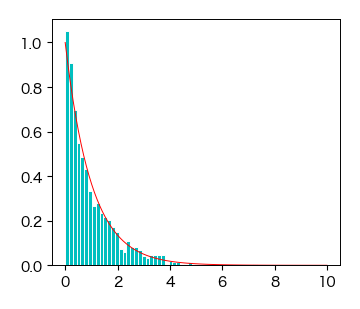

In [28]:
# ヒストグラムの描画
fig, ax = plt.subplots()
ret = ax.hist(R_exp, bins=50, density=1, color='c', edgecolor='w')

# パラメータlmdの指数分布の描画
x = np.linspace(0, 10, 100)
ax.plot(x, expon.pdf(x, scale=lmd), 'r-');

#### Box-Muller法（正規分布）

正規分布の場合は，中心極限定理（後述）を用いた方法やボックス・ミュラー法が知られている．
ボックスミュラー法は，$ [0, 1) $ の一様乱数 $ U_{1},\ U_{2} $ から標準正規分布に従う正規乱数 $ Z_{1},\ Z_{2} $ を生成することができる．

```{admonition} ボックスミュラー法のアルゴリズム
1. $ [0, 1) $ の一様乱数 $ U_1, U_2 $ を生成する．
2. 以下の式で一様乱数を変換する：

    \begin{align*}
    Z_1 &= \sqrt{-2 \log U_1} \cos(2 \pi U_2)\\
    Z_2 &= \sqrt{-2 \log U_1} \sin(2 \pi U_2)
    \end{align*}

```

In [10]:
# 線形合同法で[0, 1)の一様乱数を生成する
U1 = lcg(seed=10, size=10000, umin=0, umax=1)
U2 = lcg(seed=20, size=10000, umin=0, umax=1)

# Box-Muller法で正規乱数に変換する
Z1 = np.sqrt(-2*np.log(U1))*np.cos(2*np.pi*U2)
Z2 = np.sqrt(-2*np.log(U1))*np.sin(2*np.pi*U2)

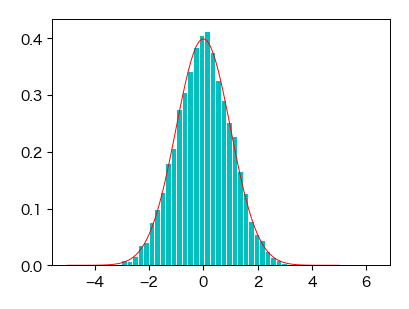

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))

# 生成した乱数によるヒストグラムの描画
ret1 = ax.hist(Z1, bins=50, density=1, color='c', edgecolor='w')

# 標準正規分布の描画
x = np.linspace(-5, 5, 100)
ax.plot(x, norm.pdf(x), 'r-');

#### 複雑な確率分布の場合

逆関数法は累積分布関数の逆関数が求まる場合にしか適用できなかったが，どんな確率分布にも適用できる方法として，[棄却法](https://en.wikipedia.org/wiki/Rejection_sampling)がある．
また，マルコフ連鎖に基づいて任意の確率分布に従う乱数を生成するマルコフ連鎖モンテカルロ法（MCMC）は，主にベイズ推定を始めとして様々な分野で用いられている．

## ベルヌーイ過程

以下のような試行を**ベルヌーイ試行**と呼ぶ：

- 1回の試行において，起こりうる事象が2種類しかない
- 各事象が起こる確率は一定である
- 各試行は独立である


通常は，2種類の事象をそれぞれ成功（1），失敗（0）に対応付けた確率変数 $ U $ を考え，成功確率を $ p $，失敗確率を $ 1-p $ とする．
このとき，確率変数 $ U $ の従う確率分布は

$$
	P(U=u) = p^{u}(1-p)^{1-u} 
$$

となり，これを**ベルヌーイ分布**と呼ぶ．
例えば，コイン投げは典型的なベルヌーイ試行である．

ベルヌーイ試行を繰り返すとき，これを**ベルヌーイ過程**と呼ぶ．
多くの基本的な確率分布はベルヌーイ過程を基に導くことができる．
以下にいくつかの例を示す．

- **二項分布**：ベルヌーイ過程において，成功回数が従う確率分布．
- **正規分布**：ベルヌーイ過程において，試行回数が十分大きい場合の成功回数の分布．
- **幾何分布**：ベルヌーイ過程において，初めて成功するまでの失敗回数が従う確率分布．
- **負の二項分布**：ベルヌーイ過程において， $ r $ 回目の成功が起こるまでの失敗回数が従う確率分布．
- **ポアソン分布**：ベルヌーイ過程において，成功確率 $ p $ が小さく，試行回数 $ n $ が大きいときに $ np=一定 $ の条件の下で成功回数が従う確率分布．

### 二項分布

ベルヌーイ試行を $ n $ 回繰り返すとき，成功回数 $ X=\displaystyle\sum_{i=1}^{n} U_{i} $ を新たな確率変数とする．
このとき，成功が $ x $ 回，失敗が $ n-x $ 回生じたとすると，その確率分布は**二項分布**

$$
	f(x) = \binom{n}{x}p^{x}(1-p)^{n-x}
$$

で与えられる．
この式において，$ p^{x}(1-p)^{n-x} $ は成功が $ x $ 回，失敗が $ n-x $ 回生じる確率を意味する．
また，$ \binom{n}{x} $ は $ n $ 個から $ x $ を取り出す組み合わせの数 $ _{n}C_{x} $ を表し，$ n $ 回の中で何回目に成功するかの場合の数に対応する．
なお，$ n=1 $ の場合はベルヌーイ分布に対応する．

二項分布は試行回数 $ n $ と成功確率 $ p $ がパラメータであり，これらによって分布の形が決まる．

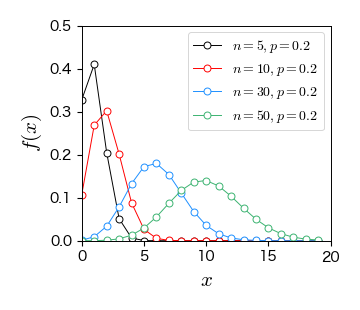

In [13]:
# 試行回数nを変化させた場合の二項分布の変化
fig, ax = plt.subplots()
k = np.arange(0, 20, 1)
for n in [5, 10, 30, 50]:
    ax.plot(k, binom.pmf(k, n=n, p=0.2), '-o', mfc='w', ms=5, label='$n=%s, p=0.2$' % n)

ax.set_xlim(0, 20); ax.set_ylim(0, 0.5)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$f(x)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

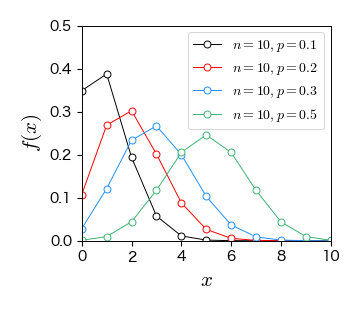

In [14]:
# 成功確率pを変化させた場合の二項分布の変化
fig, ax = plt.subplots()
k = np.arange(0, 20, 1)
for p in [0.1, 0.2, 0.3, 0.5]:
    ax.plot(k, binom.pmf(k, n=10, p=p), '-o', mfc='w', ms=5, label='$n=10, p=%s$' % p)

ax.set_xlim(0, 10); ax.set_ylim(0, 0.5)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$f(x)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

#### 演習問題

- 確率変数 $ X $ が二項分布に従うとき，その期待値と分散が $ E(X) = np $，分散が $ V(X) = np(1-p) $ となることを示せ．

### ポアソン分布

ベルヌーイ試行を独立に $ n $ 回繰り返すとき，成功確率 $ p $ が小さく，かつ試行回数 $ n $ が大きい場合を考える．
ただし，極限を取る際に平均値が一定値 $ np=\lambda $ になるようにする．
このような条件で成功回数 $ X $ が従う分布は，二項分布の式に $ np=\lambda $ を代入し，極限 $ p\to 0,\ n\to \infty $ を取ることで

$$
	f(x) = \frac{\lambda^{x}}{x!} \mathrm{e}^{-\lambda}
$$

と求まる．
これを**ポアソン分布**と呼ぶ．
ポアソン分布は1つのパラメータ $ \lambda $ だけで特徴づけられ，期待値と分散はともに $ \lambda $ となる．

ポアソン分布は，一定の期間内（例えば１時間や１日）に，稀な現象（$ p\to 0 $）を多数回試行（$ n\to \infty $）した場合にその発生回数が従う分布である．
ポアソン分布が現れる例は無数にあり，「1日の交通事故件数」，「1分間の放射性元素の崩壊数」，「1ヶ月の有感地震の回数」，「サッカーの試合における90分間の得点数」などは典型例である．

以下は $ np=5 $ に保って $ n $ を大きく，$ p $ を小さくしたときの二項分布（実線）と $ \lambda=5 $ のポアソン分布（o）の比較である．
$ n=80,\ p=1/16 $ になると，二項分布とポアソン分布はほとんど一致していることが分かる．

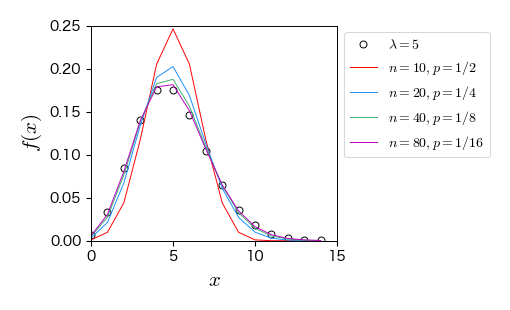

In [73]:
fig, ax = plt.subplots(figsize=(5, 3))
x = np.arange(0, 15, 1)
ax.plot(k, poisson.pmf(x, mu=5), 'o', mfc='w', ms=5, label='$\lambda=5$')
for i in np.arange(4):
    p, n = 1/2**(i+1), 10*2**i
    ax.plot(k, binom.pmf(x, n=n, p=p), '-', mfc='w', ms=5, label='$n=%s, p=1/%s$' % (n, 2**(i+1)))

ax.legend(numpoints=1, fontsize=10, loc='upper left', frameon=True, bbox_to_anchor=(1, 1))
ax.set_xlim(0, 15); ax.set_ylim(0, 0.25)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$f(x)$', fontsize=15);

**$ \lambda $が大きいとき**

ポアソン分布は $ \lambda \to \infty $ において正規分布に近づくことが知られている．
以下は $ \lambda $ を変化させた場合の分布の変化である．
$ \lambda $ が小さいときには左右非対称な分布となるが，$ \lambda $ が大きくなると左右対称な分布に近づくことが分かる．

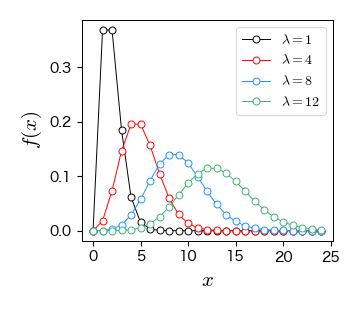

In [11]:
fig, ax = plt.subplots()
k = np.arange(0, 25, 1)
for lmd in [1, 4, 8, 12]:
    ax.plot(k, poisson.pmf(k, lmd, 1), '-o', mfc='w', ms=5, label='$\lambda=%s$'% lmd)

ax.set_xlabel('$x$', fontsize=15); ax.set_ylabel('$f(x)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

#### 演習問題
1. ポアソン分布の期待値と分散が共に $ \lambda $ であることを示せ．
2. [score_germany.csv](https://drive.google.com/uc?export=download&id=13mj2GFFNrj8F75K6FW9SPxfTTSGCXlh8)は，ブンデスリーガの2017-2018シーズンにおける一方のチームの１試合の得点数データである．このデータからヒストグラムを作成し，ポアソン分布によってカーブフィッティングせよ（最小二乗法を用いること）．
3. [score_nba.csv](https://drive.google.com/uc?export=download&id=1kVrg4GjjcE_DC-78U0BArBAglJeiwQgr)は，NBAの2015-16シーズンにおける一方のチームの１試合の得点数データである．このデータからヒストグラムを作成し，ポアソン分布によってカーブフィッティングせよ（最小二乗法を用いること）．
4. 2.と3.の結果を比較し，ポアソン分布の特徴を考察せよ．

## 大数の法則と中心極限定理
<!-- 
### ベルヌーイ試行

### 二項分布

### 大数の法則

### 中心極限定理

## ランダムウォーク -->

### 大数の法則

#### ベルヌーイ過程の場合

既にベルヌーイ過程における成功回数 $ X=\displaystyle\sum_{i=1}^{n} U_{i} $ が二項分布に従うことを見たが，ここでは $ X $ を $ n $ で割った標本平均（成功割合）

$$
	T = \frac{X}{n} = \frac{1}{n}\displaystyle\sum_{i=1}^{n} U_{i}
$$

を新しい確率変数とする．
このとき， $ T $ の確率分布を $ g(t) $ とすると，$ g(t) $ も二項分布に従い，$ g(t)=nf(nt) $ の関係にある．

以下は成功確率 $ p $ を一定値 $ p=0.2 $ に固定して，試行回数 $ n $ を大きくしたときの標本平均 $ T $ の確率分布である．
この図を見ると，$ n $ の増加に伴って $ t=0.2 $ の周りに分布が集中するとともに，高さが大きくなる様子が分かる．

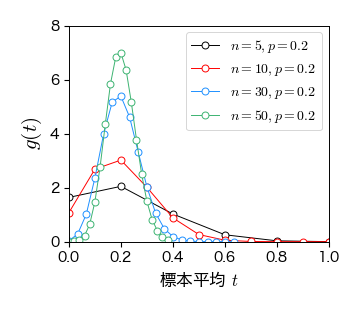

In [ ]:
fig, ax = plt.subplots()
k = np.arange(0, 20, 1)

for n in [5, 10, 30, 50]:
    ax.plot(k/n, n*binom.pmf(k, n=n, p=0.2), '-o', mfc='w', ms=5, label='$n=%s, p=0.2$' % n)

ax.set_xlim(0, 1); ax.set_ylim(0, 8)
ax.set_xlabel('標本平均 $t$', fontsize=12)
ax.set_ylabel('$g(t)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

以上のような図の変化を数式で確認する．
まず，成功回数 $ X $ の期待値と分散はそれぞれ $ E(X)=np,\ V(X)=np(1-p) $ であるから，成功割合 $ T=X/n $ の期待値と分散はそれぞれ $ E(T)=p,\ V(T)=p(1-p)/n $ となる．
これより，成功割合 $ T=X/n $ の期待値は $ n $ に依らず一定 $ p $ で，分散は $ n $ とともに0に近づくことが分かる．
これが，成功割合 $ T=X/n $ の分布が試行回数 $ n $ の増加とともに $ p $ の近くに集中する理由である．

以上のように，ベルヌーイ過程においては，試行回数 $ n\to \infty $ の極限で成功割合 $ T=X/n $ が理論値 $ p $ に一致する．
このように，確率変数の標本平均が理論値に一致する性質は**大数の法則**と呼ばれている．

#### 大数の法則（一般の場合）

大数の法則は，一般の確率分布に従う確率変数列について成り立つ法則であり，以下のように表される．

```{admonition} 大数の法則
独立同分布に従う $ n $ 個の確率変数 $ U_{1}, U_{2},\ldots, U_{n} $ に対し，それぞれの期待値（母平均）を $ \mu $ とする．
このとき，確率変数列の標本平均 $ \displaystyle T=\frac{1}{n}\sum_{i=1}^{n}U_{i} $ は $ n\to\infty $ で $ \mu $ に一致する．
```

以下は，様々な確率分布に対する大数の法則のシミュレーションである．

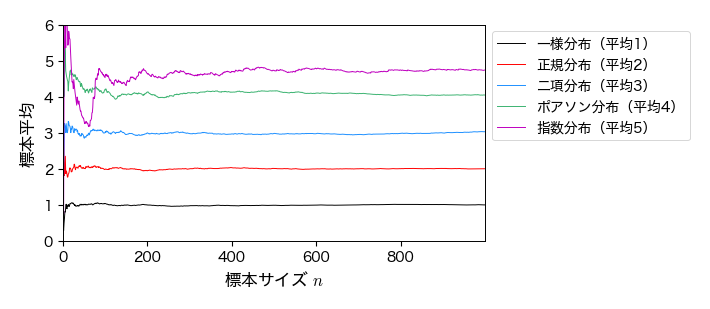

In [150]:
N = np.arange(1, 1000)

# 様々な確率分布からサイズnの標本を生成する
U_uni = uniform.rvs(loc=0, scale=2, size=len(N)) # 一様分布（平均1）
U_norm = norm.rvs(loc=2, scale=1, size=len(N))   # 正規分布（平均2）
U_binom = binom.rvs(n=10, p=0.3, size=len(N))    # 二項分布（平均3）
U_poisson = poisson.rvs(mu=4, size=len(N))       # ポアソン分布（平均4）
U_expon = expon.rvs(scale=5, size=len(N))        # 指数分布（平均5）

# 様々な標本サイズnに対して標本平均を計算
T_uni, T_norm, T_binom, T_poisson, T_expon = [], [], [], [], []
for n in N:
    T_uni.append(U_uni[:n].mean())
    T_norm.append(U_norm[:n].mean())
    T_binom.append(U_binom[:n].mean())
    T_poisson.append(U_poisson[:n].mean())
    T_expon.append(U_expon[:n].mean())

# 標本平均の変化をプロット
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(N, np.array(T_uni), '-', label='一様分布（平均1）')
ax.plot(N, np.array(T_norm), '-', label='正規分布（平均2）')
ax.plot(N, np.array(T_binom), '-', label='二項分布（平均3）')
ax.plot(N, np.array(T_poisson), '-', label='ポアソン分布（平均4）')
ax.plot(N, np.array(T_expon), '-', label='指数分布（平均5）')

ax.set_xlim(0, len(N)); ax.set_ylim(0, 6)
ax.set_xlabel('標本サイズ $n$', fontsize=12)
ax.set_ylabel('標本平均', fontsize=12)
ax.legend(numpoints=1, fontsize=10, loc='upper left', frameon=True, bbox_to_anchor=(1, 1));

### 中心極限定理

ベルヌーイ過程において，$ n $ 回のベルヌーイ試行を１セットとして，成功回数 $ X $ や成功割合（標本平均） $ T $ を求める．
これを何セットも繰り返すと，$ X $ や $ T $ の分布が得られ，いずれも二項分布に従うが，$ n $ を大きくしていくと左右非対称な分布から左右対称な分布へと変化する．
この $ n $ を十分大きくしたときに出現する左右対称で滑らかな分布は**正規分布**であることが知られている．

以上はベルヌーイ過程の場合であるが，実は一般の確率分布に従う確率変数列についても，$ n $ が十分大きいとき，確率変数列の和や標本平均は正規分布に近づくことが知られている．
この性質は**中心極限定理**と呼ばれており，より具体的には以下のように表される．

```{admonition} 中心極限定理
独立同分布に従う $ n $ 個の確率変数 $ U_{1}, U_{2},\ldots, U_{n} $ に対し，それぞれの母平均を $ \mu $，母分散を $ \sigma^2 $ とする．このとき，確率変数列の標本平均 $ \displaystyle T=\frac{1}{n}\sum_{i=1}^{n}U_{i} $ の分布 $ g(t) $ が $ n $ を大きくしたときに正規分布 $ N(\mu, \sigma^{2}/n) $ に近づく
```

#### ベルヌーイ分布の場合

確率変数列 $ U_{1}, U_{2},\ldots, U_{n} $ が成功確率 $ p $ のベルヌーイ分布に従うとき，期待値は $ p $，分散は $ p(1-p) $である．
よって，中心極限定理によると，標本平均の分布は $ n $ を大きくしたときに正規分布 $ N(p, p(1-p)/n) $ に近づく．

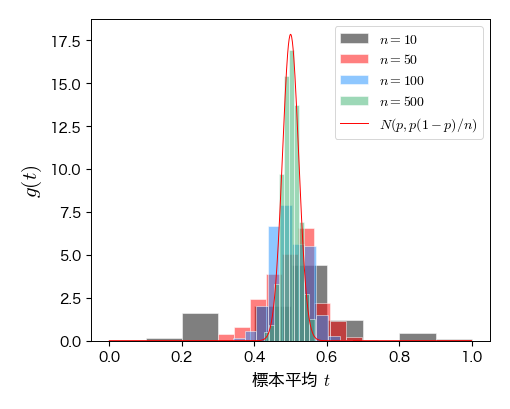

In [3]:
fig, ax = plt.subplots(figsize=(5, 4))

# 様々な標本サイズnに対して標本平均のヒストグラムを描画
p=0.5
for n in [10, 50, 100, 500]:

    # 標本平均を1000回計算してヒストグラムを描画
    T = []
    for j in range(1000):
        U = sp.stats.bernoulli.rvs(p, size=n) # 確率pのベルヌーイ分布からサイズnの標本を生成
        T.append(U.mean())
    ax.hist(T, bins=10, density=1, edgecolor='w', alpha=0.5, label='$n=%s$' % n); 

# 正規分布N(\mu, \sigma^2/n)の確率密度関数を描画
t = np.arange(0, 1, 0.001)
gt = sp.stats.norm.pdf(t, loc=p, scale=np.sqrt(p*(1-p)/n))
ax.plot(t, gt, 'r-', label='$N(p, p(1-p)/n)$')

ax.set_xlabel('標本平均 $t$', fontsize=12)
ax.set_ylabel('$g(t)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

#### ポアソン分布の場合

確率変数列 $ U_{1}, U_{2},\ldots, U_{n} $ がパラメータ $ \lambda $ のポアソン分布に従うとき，期待値と分散は共に $ \lambda $である．
よって，中心極限定理によると，標本平均の分布は $ n $ を大きくしたときに正規分布 $ N(\lambda, \lambda/n) $ に近づく．

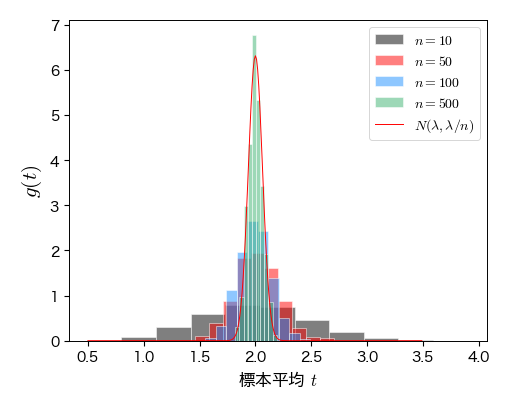

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))

# 様々な標本サイズnに対して標本平均のヒストグラムを描画
lmd=2
for n in [10, 50, 100, 500]:

    # 標本平均を1000回計算してヒストグラムを描画
    T = []
    for j in range(1000):
        U = sp.stats.poisson.rvs(lmd, size=n) # パラメータlmdのポアソン分布からサイズnの標本を生成
        T.append(U.mean())
    ax.hist(T, bins=10, density=1, edgecolor='w', alpha=0.5, label='$n=%s$' % n); 

# 正規分布N(\mu, \sigma^2/n)の確率密度関数を描画
t = np.arange(0.5, 3.5, 0.01)
gt = sp.stats.norm.pdf(t, loc=lmd, scale=np.sqrt(lmd/n))
ax.plot(t, gt, 'r-', label='$N(\lambda, \lambda/n)$')

ax.set_xlabel('標本平均 $t$', fontsize=12)
ax.set_ylabel('$g(t)$', fontsize=15)
ax.legend(numpoints=1, fontsize=10, loc='upper right', frameon=True);

#### 演習問題

確率変数列 $ U_{1}, U_{2},\ldots, U_{n} $ がその他の確率分布に従う場合について上と同様のシミュレーションを行い，中心極限定理が成り立つことを確認せよ．

## マルコフ連鎖

### マルコフ連鎖の定式化

ベルヌーイ過程は，１回の試行で取りうる状態が2つ（成功／失敗）だけで，それぞれの出現確率が一定値（$ p,\ 1-p $）であったが，これを次のように拡張する：

1. 各時刻で取りうる状態が離散的で2つ以上
2. 次の時刻に取りうる状態が現在の状態だけに依存して決まる（**マルコフ性**）

以上のような確率過程を**マルコフ連鎖**と呼ぶ．

#### 遷移確率

時刻 $ t $ の状態を確率変数 $ U_{t} $ によって表す．
$ U_{t} $ は離散的な状態 $ \{0, 1, 2, \ldots\} $ を取るものとする（取りうる状態の集合を**状態空間**と呼ぶ）．
このとき，マルコフ性は以下のように表される：

$$
     P(U_{t+1}=j|U_{t}=i, U_{t-1}, \ldots, U_{0}) = P(U_{t+1}=j|U_{t}=i)
$$

これは，時刻 $ t+1 $ に状態 $ j $ を取る確率が，時刻 $ t $ の状態だけで決まることを表している．
以下ではこの確率を

$$ 
    P(U_{t+1}=j|U_{t}=i) = p_{ij} 
$$

と表し，これを状態 $ i $ から $ j $ への**遷移確率**と呼ぶ．
また，遷移確率 $ p_{ij} $ を $ (i,j) $ 成分とする行列を**遷移確率行列**と呼び，$ P $ と表す．
なお，遷移確率は時刻 $ t $ に依らず一定であるとする（これを時間的に一様なマルコフ連鎖と呼ぶ）．
マルコフ連鎖は，各状態間を遷移確率に従って次々に移動するようなイメージを持つと理解しやすい．

マルコフ連鎖の具体例として，状態空間が $ S=\{0, 1, 2\} $ の場合を考える．
{numref}`fig:markov_chain`は，状態間の遷移確率を可視化したもので，**状態遷移図**と呼ばれる．
この場合の遷移確率行列は次のように与えられる：

$$
    P = \begin{pmatrix}
        p_{00} & p_{01} & p_{02} \\
        p_{10} & p_{11} & p_{12} \\
        p_{20} & p_{21} & p_{22}
    \end{pmatrix}
    = \begin{pmatrix}
        0.5 & 0.3 & 0.2 \\
        0.2 & 0.5 & 0.3 \\
        0.3 & 0.2 & 0.5
    \end{pmatrix}
$$

ここで，遷移確率行列は各行の和が必ず1になることに注意する．
これは，次の時刻で必ずいずれかの状態に遷移することを意味している．

```{figure} ../figure/markov_chain.png
---
height: 250px
name: fig:markov_chain
---
マルコフ連鎖の状態遷移図
```

#### 状態ベクトル

時刻 $ t $ に状態 $ i $ を取る確率を 

$$ 
    P(U_{t}=i)=w^{(t)}_{i} 
$$

と表し，全状態を並べたベクトル $ \boldsymbol{w}_{t} $ を**状態ベクトル**と呼ぶ．
状態ベクトルは確率分布を表し，3状態の場合は $ \boldsymbol{w}_{t} = [w^{(t)}_{0}, w^{(t)}_{1}, w^{(t)}_{2}] $ と表される．
（※ ベルヌーイ過程の場合，状態ベクトルはベルヌーイ分布を意味する．）

時刻 $ t+1 $ の状態ベクトル $ \boldsymbol{w}_{t+1} $ は，時刻 $ t $ の状態ベクトル $ \boldsymbol{w}_{t} $ と遷移確率行列 $ P $ を用いて

$$
    \boldsymbol{w}_{t+1} = \boldsymbol{w}_{t}P  
$$

と表すことができる．
すなわち，状態ベクトルは遷移確率行列をかけることで次の時刻の状態ベクトルに変化する．
これより，初期状態ベクトル $ \boldsymbol{w}_{0} $ が与えられたとき，時刻 $ t $ の状態ベクトルは

$$
    \boldsymbol{w}_{t} = \boldsymbol{w}_{0}P^{t}
$$

と表される．

例えば，{numref}`fig:markov_chain`の場合について，初期状態ベクトル $ \boldsymbol{w}_{0} = [1, 0, 0] $ が与えられたとき，時刻 $ 1 $ の状態ベクトルは次のようになる：

$$
    \boldsymbol{w}_{1} = \boldsymbol{w}_{0}P = [1, 0, 0] \begin{pmatrix}
        0.5 & 0.3 & 0.2 \\
        0.2 & 0.5 & 0.3 \\
        0.3 & 0.2 & 0.5
    \end{pmatrix} = [0.5, 0.3, 0.2]
$$

#### マルコフ連鎖の定常状態

状態ベクトルは遷移を繰り返すことによって変化していくが，もしそれ以上変化しなくなった場合，これを**定常状態**と呼ぶ．
定常状態の状態ベクトル $ \boldsymbol{w} $ は遷移確率行列 $ P $ をかけても変化しないので，

$$
     \boldsymbol{w}P = \boldsymbol{w}
$$

という式を満たす．
ここで，この式の両辺の転置を取ると，

$$
    P^{\top}\boldsymbol{w}^{\top} = \boldsymbol{w}^{\top}
$$

となることから，$ \boldsymbol{w}^{\top} $ は行列$ P^{\top} $の固有値1に対応する固有ベクトルであることが分かる．

### マルコフ連鎖の例

#### 具体例

あるスポーツにおいて，Aチームの得点を状態0，Bチームの得点を状態1で表す．
Aチームが連続して得点する確率を0.8，Bチームが連続して得点する確率を0.7とすると，{numref}`fig:markov_chain_2` のような状態遷移図が得られ，遷移確率行列は次のように与えられる：

$$
    P = \begin{pmatrix}
        0.8 & 0.2 \\
        0.3 & 0.7 
    \end{pmatrix}
$$

この遷移確率行列から，例えば，最初（時刻0）にAチームが得点した場合の時刻$ 2 $における状態ベクトルは

$$
    \boldsymbol{w}_{2} = \boldsymbol{w}_{0}P^{2} = [1, 0] \begin{pmatrix}
        0.8 & 0.2 \\
        0.3 & 0.7 
    \end{pmatrix}^{2} = [0.68, 0.32]
$$

となる．

定常分布は転置行列 $ P^{\top} $ の固有値1に対応する固有ベクトルとして求まる．
まずは，$ P^{\top} $ が固有値1を持つことを確かめるため，固有値方程式

$$
    |P^{\top}-\lambda I| = 0
$$

を解いてみる（$ I $ は単位行列）．
この固有値方程式は

$$
    \begin{vmatrix}
        0.8-\lambda & 0.3 \\
        0.2 & 0.7-\lambda
    \end{vmatrix}
    = 0
$$

となるのでこれを解くと，$ \lambda_{1}=1 $ と $ \lambda_{2}=0.5 $ が得られ，確かに固有値1を持つことが分かる．

次に，固有値1に対する固有ベクトルを求める．
関係式 $ P^{\top}\boldsymbol{w}^{\top}=\boldsymbol{w}^{\top} $ は

$$
    \begin{pmatrix}
        0.8 & 0.3 \\
        0.2 & 0.7 
    \end{pmatrix}
    \begin{pmatrix}
        w_{0} \\
        w_{1}
    \end{pmatrix}
    = \begin{pmatrix}
        w_{0} \\
        w_{1}
    \end{pmatrix}
$$

と書けるので，これより $ w_{1} = \frac{2}{3}w_{0} $　が得られる．
よって，確率の条件 $ w_{0}+w_{1}=1 $ を満たすような固有ベクトルは

$$
    \begin{pmatrix}
    w_{0}\\
    w_{1}
    \end{pmatrix}
    =
    \begin{pmatrix}
    0.6\\
    0.4
    \end{pmatrix}
$$

と求まる．

```{figure} ../figure/markov_chain_2.png
---
height: 80px
name: fig:markov_chain_2
---
２状態マルコフ連鎖の状態遷移図

```

#### 応用例

マルコフ連鎖は自然現象から社会現象に至るまで，様々な現象をモデル化するために用いられる．

- 株価変動のモデル
- 言語生成のモデル
- 球技におけるパス回しのモデル

また，具体的な現象のモデル以外にも多くの応用例がある．

- GoogleのPageRank
- マルコフ連鎖モンテカルロ法


### Pythonによる実装

以下のデータは，ある都市の30日間の天気を0（＝晴れ），1（＝曇），2（＝雨）の3つの状態で表したものである．

In [16]:
data = [0,0,2,1,0,0,0,0,1,0,0,1,2,2,2,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1]

**遷移確率行列の推定**

まず，遷移確率 $ p_{ij} $ を以下の式で推定する：

$$
    p_{ij} = \frac{N_{ij}}{N_{i}}
$$

ここで，$ N_{ij} $ は状態 $ i $ から $ j $ への遷移回数，$ N_{i} $ は状態 $ i $ の出現回数である．

In [17]:
# 時刻kとk+1のデータをデータフレームに格納
df = pd.DataFrame({'t': data[:-1], 't+1': data[1:]})
df.head(3)

,t,t+1
0,0,0
1,0,2
2,2,1


In [18]:
# 遷移確率行列の推定
P = np.zeros([3, 3])
for i in range(3):
    for j in range(3):
        P[i, j] = len(df.loc[(df['t']==i) & (df['t+1']==j)])/len(df.loc[df['t']==i])

In [19]:
P

array([[0.66666667, 0.27777778, 0.05555556],
       [0.57142857, 0.28571429, 0.14285714],
       [0.25      , 0.25      , 0.5       ]])

**マルコフ連鎖の計算**

遷移確率行列 $ P $ が求まったら，任意の初期状態ベクトル $ \boldsymbol{w}_{0} $ と $ P $ との行列積を繰り返し計算すれば良い．
NumPy配列の行列積は `np.dot()` で計算できる．
今回の遷移確率行列の場合は，どんな初期状態ベクトルに対しても，最終的には同じ定常状態に収束することが確認できる．

In [28]:
# 初期状態分布
w0 = np.array([0.2, 0.1, 0.7])
w0 = w0/np.sum(w0) # 規格化

# マルコフ連鎖の計算
W_all, w = w0, w0
for t in range(len(data)):
    w = np.dot(w, P)
    W_all = np.vstack([W_all, w])
w

array([0.58064516, 0.27598566, 0.14336918])

(0.0, 1.0)

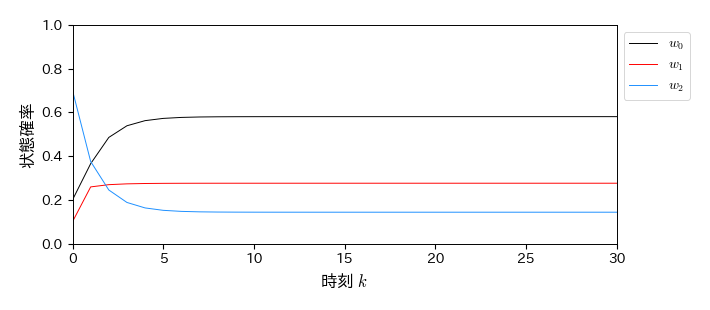

In [29]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(3):
    ax.plot(W_all[:, i], label='$w_%s$' % i)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, frameon=True)
ax.set_xlabel('時刻 $k$', fontsize=12)
ax.set_ylabel('状態確率', fontsize=12)
ax.set_xlim(0, 30); ax.set_ylim(0, 1)

### 演習問題

- 上の具体例で扱った2状態マルコフ連鎖について，定常状態の状態ベクトルを数値的に求めよ．
- マルコフ連鎖の応用例について調べよ．